# 07  t-Tests - Task 1

Provide a script and html file which calulates the suitable T-Tests to answer the following research questions (RQ). Please also test the requirements for each test, and, report the results in one sentence including the test statistic value with degree of freedom, significance value as well as effect size.

1.RQ (regarding DB01): Does increasing the bitrate (independent variable) from 2000 kbps to 6000 kbps for the first game using a resolution of 1080p and a framerate of 60 fps (conditions 36 and 50) significantly improve the video quality ratings (dependent variable). Use the ratings provided in the gaming video quality dataset. In case of an extreme outlier, the participant can be completely removed from the dataset.

## Import and Initializing

In [34]:
import numpy as np
import pandas as pd
import scipy


# !pip3 install factor_analyzer --user
from factor_analyzer.utils import corr, impute_values, partial_correlations, smc
from factor_analyzer.factor_analyzer import calculate_kmo

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="talk")

FIGSIZE = (20,4)

## Loading the data

In [55]:
dataset = pd.read_excel("../datasets/DB01_gaming_video_quality_dataset.xlsx", usecols=["PID", "Game", "Condition", "VQ"]).dropna()

mask = (dataset['Game'] == 'Game1') & ((dataset['Condition'] == 36) | (dataset['Condition'] == 50))
dataset = dataset[mask]
dataset = dataset.drop(columns='Game')

## Check general requirements

### Eliminate the outliers

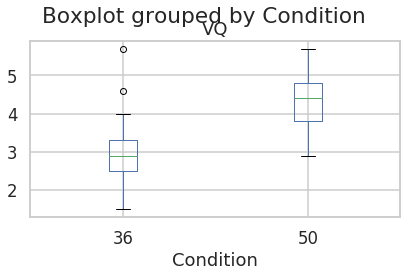

In [56]:
ax = dataset.boxplot(column="VQ", by="Condition")
ax.figure.tight_layout()

In [57]:
# get every participant who causes outlier
outliers = dataset.query("~((VQ <= 4 & Condition == 36) | Condition == 50)")
outlier_list = outliers['PID'].tolist()

#delete every participant who causes outlier
for outlier_pid in outlier_list:
    dataset = dataset[dataset['PID']!=outlier_pid]

### Measurement

The dependent variable (VQ) is measured at the interval level.

## Check specific requirements for dependent t-test

### The independent variable should consist of two categorical, related groups

The bitrate consists of two categorical, related groups (2.000 kbps (Condition=36) and 6.000 kbps (Condition=50)).

### The distribution of the differences in the dependent variable between the two related groups should be approximately normally distributed

In [62]:
group1 = dataset[dataset['Condition'] == 36]
group2 = dataset[dataset['Condition'] == 50]

group1 = group1.rename(columns={'VQ':'VQ-1'})
group2 = group2.rename(columns={'VQ':'VQ-2'})

group1=group1.set_index("PID")
group2=group2.set_index("PID")

group1 = group1.drop(columns=["Condition"])
group2 = group2.drop(columns=["Condition"])

vqs = pd.concat([group1, group2], axis=1)

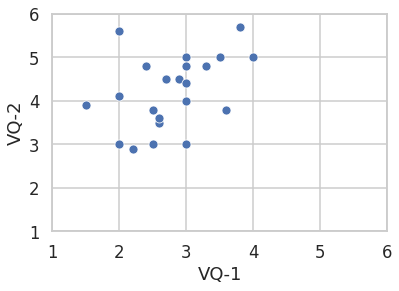

In [63]:
ax = sns.scatterplot(vqs["VQ-1"], vqs["VQ-2"])
plt.axis([1, 6, 1, 6])
#ax.plot([1,6], [1, 6], color="red")
None

## Dependent t-test

In [66]:
rel_ttest_result = scipy.stats.ttest_rel(vqs["VQ-1"], vqs["VQ-2"])

print("Dependent T-test")
print(f"\tt-statistic: {rel_ttest_result.statistic:f}")
print(f"\tp-value: {rel_ttest_result.pvalue:.10f}")

Dependent T-test
	t-statistic: -8.724897
	p-value: 0.0000000136


The p-value is nearly null, so the null hypothesis (which says that the averages of both classes are close to each other) can be rejected. That means, that increasing the bitrate from 2.000 kbps to 6.000 kbps is significantly improving the video quality ratings.

### Degrees of Freedom
> #### Dependent t-test for paired samples
> [...]
> The degree of freedom used is $n − 1$, where $n$ represents the number of pairs. 

Source: https://en.wikipedia.org/wiki/Student's_t-test#Dependent_t-test_for_paired_samples

In [68]:
dof = vqs.shape[0] - 1
print(f"Degrees of freedom: {dof}")

Degrees of freedom: 22


### Effect Size Using Cohen's d
$$d = \frac{\mu_{2000} - \mu_{6000}}{s_p}$$
where $\mu_{2000}$ and $\mu_{6000}$ are the averages of the respective conditions and $s_p$ refers to the pooled standard diviation:<br/>
<br/>
$$s_p = \sqrt{\frac{s^2_{2000} + s^2_{6000}}{2}}$$
<br/>
where $s^2_{2000}$ and $s^2_{6000}$ are the smaple variances of the respective conditions. Please be aware that the formular for the pooled standard diviation is simplified in this case since the degrees of freedom for both groups is equal and cancel each other out.

Source: https://en.wikipedia.org/wiki/Effect_size#Cohen's_d

In [71]:
mu_2000 = vqs["VQ-1"].mean()
mu_6000 = vqs["VQ-2"].mean()

s2_2000 = vqs["VQ-1"].var()
s2_6000 = vqs["VQ-2"].var()

s_p = np.sqrt((s2_2000 + s2_6000) / 2)

d = (mu_2000 - mu_6000) / s_p

print(f"Cohen's d: {d}")

Cohen's d: -1.9977708546236204


**Conclusion**: This corresponds to a _very large_ effect size.